In [3]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(0, n_width-width+1)
        y = np.random.randint(0, n_height-height+1)
#         x = np.random.randint(n_width-width)
#         y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 8

(x_train, y_train), (x_test, y_test_orig) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test_orig)

In [4]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model = keras.models.load_model('../models/51_1split_2.h5')
# es = EarlyStopping(monitor='val_classifier_out_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('../models/56_16split_2_class_regr_latent128.h5', monitor='val_regressor_out_loss', mode='min', save_best_only=True, verbose=1)

losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 0.0,
    'classifier_out' : 1,
    'regressor_out' : 1
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
# model.load_weights('../models/56_16split_2_class_regr_latent128.h5')
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam')

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=150, batch_size=32, callbacks=[mc])

# import matplotlib.pyplot as plt

# plt.plot(history.history['classifier_out_accuracy'])
# plt.plot(history.history['val_classifier_out_accuracy'])
# plt.title('No-Split training')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.grid(b=True, which='major', color='#666666', linestyle='-')
# plt.savefig('../img/56_PLOTS/16split_class+regr_latent_128.png', dpi=200)

Epoch 1/150
1875/1875 [==============================] - ETA: 0s - loss: 9.4285 - classifier_out_loss: 2.1690 - decoder_out_loss: 0.2419 - regressor_out_loss: 7.2594
Epoch 00001: val_regressor_out_loss improved from inf to 3.23564, saving model to ../models/56_16split_2_class_regr_latent128.h5
1875/1875 [==============================] - 27s 14ms/step - loss: 9.4285 - classifier_out_loss: 2.1690 - decoder_out_loss: 0.2419 - regressor_out_loss: 7.2594 - val_loss: 5.2115 - val_classifier_out_loss: 1.9758 - val_decoder_out_loss: 0.2422 - val_regressor_out_loss: 3.2356
Epoch 2/150
1875/1875 [==============================] - ETA: 0s - loss: 4.4261 - classifier_out_loss: 1.9123 - decoder_out_loss: 0.2425 - regressor_out_loss: 2.5138
Epoch 00002: val_regressor_out_loss improved from 3.23564 to 1.82155, saving model to ../models/56_16split_2_class_regr_latent128.h5
1875/1875 [==============================] - 26s 14ms/step - loss: 4.4261 - classifier_out_loss: 1.9123 - decoder_out_loss: 0.242

In [5]:
import keras
# model = keras.models.load_model('../models/56_16split_2_class_regr_latent128.h5')
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.load_weights('../models/56_16split_2_class_regr_latent128.h5')

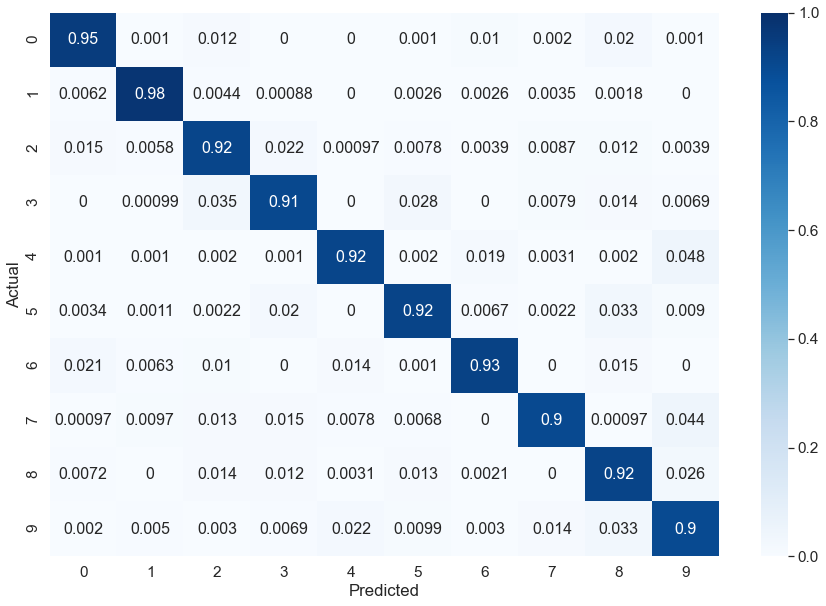

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

with tf.device('/cpu:0'):

    z = model.encode(x_test_split)
    y_pred = model.classify(z)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    conf = confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels, normalize='true')
    # conf = confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

    df_cm = pd.DataFrame(conf, range(10), range(10))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
#     print(df_cm * 100)
    
    sn.set(font_scale=1.4)
    plt.figure(figsize=(15,10))
#     ax = sn.heatmap(df_cm * 100, annot=True, fmt='.1f', annot_kws={'size':16}, cmap='Blues', vmin=0, vmax=100)
    ax = sn.heatmap(df_cm, annot=True, annot_kws={'size':16}, cmap='Blues', vmin=0, vmax=1)
#     for t in ax.texts: 
#         n = float(t.get_text())
#         if n == 0.0:
#             t.set_text("-")
#         elif n < 0.1:
#             t.set_text("<0.1%")
#         else:
#             t.set_text(t.get_text() + " %")


# unique, counts = np.unique(y_test_orig, return_counts=True)
# orig = dict(zip(unique, counts))
# print(orig)

# y_hat_hot = model(x_test_split[0].reshape(1,16,14,14,1))
# print(y_test_orig[0])
# print(np.argmax(y_hat_hot))

# cc = {i: 0 for i in range(0,10)}
# for x, y in zip(x_test_split, y_test_orig):
#     y_hat_hot = model(x.reshape(1,16,14,14,1))
#     if np.argmax(y_hat_hot) == y:
#         cc[y] += 1
# print(cc / orig)
# d1 = orig
# d2 = cc
# classif_distrib = {k: d2[k] / d1[k] for k in d1 if k in d2}
# print(classif_distrib.values)

# import matplotlib.pyplot as plt


# plt.xticks(np.arange(0,10,step=1))
# plt.yticks(np.arange(0,1.1,step=.1))
# plt.grid(b=True, axis='y', which='both', color='#666666', linestyle='-')
# plt.bar(classif_distrib.keys(), classif_distrib.values(), width=0.8, color='orangered')

# plt.savefig('../img/56_PLOTS/conf_matrix_2.png', dpi=200)

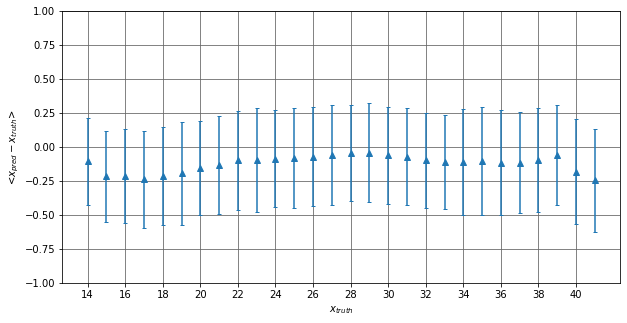

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(10, 5))
# ax = plt.gca()
# ax.set_facecolor('white')

with tf.device('/cpu:0'):

    z = model.encode(x_test_split)
    Y_pred = model.regress(z)
#     x_pred = Y_pred[:,1]
#     x_truth = y_test_regr[:,1]
    x_pred = Y_pred[:,0]
    x_truth = y_test_regr[:,0]
    sorted_pred = np.array([x for _, x in sorted(zip(x_truth, x_pred))], dtype='float32')
    sorted_truth = sorted(x_truth)
    
    delta = sorted_pred - sorted_truth
    u, s = np.unique(sorted_truth, return_index=True)
    pred_per_x = np.split(delta, s[1:])
    
    means = [np.mean(x) for x in pred_per_x]
    stds = [np.std(x) for x in pred_per_x]
    
    
    plt.grid(b=True, axis='both', which='both', color='#666666', linestyle='-')
    plt.errorbar(u, means, yerr=stds, capsize=2, linestyle='None', fmt='^')
#     plt.xlabel('$y_{truth}$')
#     plt.ylabel('<$y_{pred} - y_{truth}$>')
    plt.xlabel('$x_{truth}$')
    plt.ylabel('<$x_{pred} - x_{truth}$>')
    plt.ylim([-1,1])
    plt.xticks(np.arange(14, 42, step=2))
    
#     plt.savefig('../img/56_PLOTS/y_mean_residuals.png', dpi=200)
    plt.savefig('../img/56_PLOTS/x_mean_residuals.png', dpi=200)

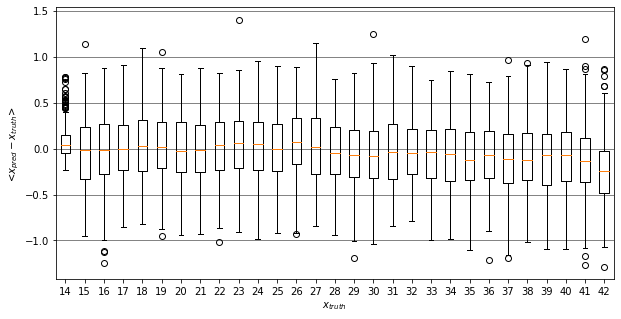

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

plt.figure(figsize=(10, 5))

with tf.device('/cpu:0'):

    z = model.encode(x_test_split)
    Y_pred = model.regress(z)
#     x_pred = Y_pred[:,1]
#     x_truth = y_test_regr[:,1]
    x_pred = Y_pred[:,0]
    x_truth = y_test_regr[:,0]
    sorted_pred = np.array([x for _, x in sorted(zip(x_truth, x_pred))], dtype='float32')
    sorted_truth = sorted(x_truth)
    
    delta = sorted_pred - sorted_truth
    u, s = np.unique(sorted_truth, return_index=True)
    pred_per_x = np.split(delta, s[1:])
    
#     means = [np.mean(x) for x in pred_per_x]
#     stds = [np.std(x) for x in pred_per_x]
    
    
    plt.grid(b=True, axis='y', which='both', color='#666666', linestyle='-')
    plt.boxplot(pred_per_x, labels=u.astype('int16'))
#     plt.errorbar(u, means, yerr=stds, capsize=2, linestyle='None', fmt='^')
#     plt.xlabel('$y_{truth}$')
#     plt.ylabel('<$y_{pred} - y_{truth}$>')
    plt.xlabel('$x_{truth}$')
    plt.ylabel('<$x_{pred} - x_{truth}$>')
#     plt.ylim([-1,1])
#     plt.xticks(np.arange(14, 42, step=2))
    
#     plt.savefig('../img/56_PLOTS/y_mean_residuals_box.png', dpi=200)
    plt.savefig('../img/56_PLOTS/x_mean_residuals_box.png', dpi=200)

In [43]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 8

(x_train, y_train), (x_test, y_test_orig) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test_orig)

Epoch 1/40
1866/1875 [============================>.] - ETA: 0s - loss: 1.8235 - acc: 0.2935
Epoch 00001: val_acc improved from -inf to 0.43610, saving model to ../models/56_16split_class_latent128.h5
1875/1875 [==============================] - 7s 3ms/step - loss: 1.8210 - acc: 0.2946 - val_loss: 1.5277 - val_acc: 0.4361
Epoch 2/40
1871/1875 [============================>.] - ETA: 0s - loss: 1.0439 - acc: 0.6242
Epoch 00002: val_acc improved from 0.43610 to 0.72270, saving model to ../models/56_16split_class_latent128.h5
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0436 - acc: 0.6244 - val_loss: 0.7922 - val_acc: 0.7227
Epoch 3/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.6948 - acc: 0.7640
Epoch 00003: val_acc improved from 0.72270 to 0.80220, saving model to ../models/56_16split_class_latent128.h5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6948 - acc: 0.7640 - val_loss: 0.5816 - val_acc: 0.8022
Epoch 4/40
1875/1875 [

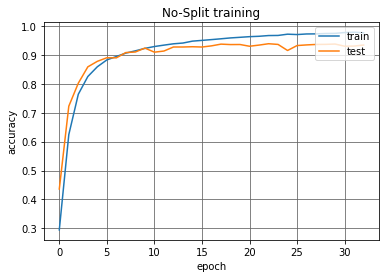

In [44]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model = keras.models.load_model('../models/51_1split_2.h5')
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('../models/56_16split_class_latent128.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=40, batch_size=32, callbacks=[mc, es])

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('No-Split training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
# plt.savefig('../img/56_PLOTS/16split_class.png', dpi=200)

<built-in method values of dict object at 0x7fa39f25fa80>


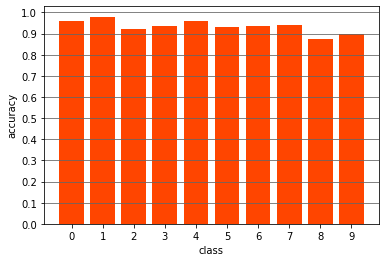

In [47]:
import numpy as np

unique, counts = np.unique(y_test_orig, return_counts=True)
orig = dict(zip(unique, counts))

d1 = orig
d2 = cc
classif_distrib = {k: d2[k] / d1[k] for k in d1 if k in d2}
print(classif_distrib.values)

# y_hat_hot = model(x_test_split[0].reshape(1,16,14,14,1))
# # print(y_test_orig[0])
# # print(np.argmax(y_hat_hot))

# cc = {i: 0 for i in range(0,10)}
# for x, y in zip(x_test_split, y_test_orig):
#     y_hat_hot = model(x.reshape(1,16,14,14,1))
#     if np.argmax(y_hat_hot) == y:
#         cc[y] += 1
# print(cc / orig)

import matplotlib.pyplot as plt

plt.xticks(np.arange(0,10,step=1))
plt.xlabel('class')
plt.ylabel('accuracy')
plt.yticks(np.arange(0,1.1,step=.1))
plt.grid(b=True, axis='y', which='both', color='#666666', linestyle='-')
plt.bar(classif_distrib.keys(), classif_distrib.values(), width=0.8, color='orangered')

plt.savefig('../img/56_PLOTS/16split_classif_distrib_latent128.png', dpi=200)